# Razonamiento Aproximado:

El conocimiento que se necesita para desarrolar un sistema basado en conocimiento, en general, es no confiable, impreciso, incompleto y contradictorio, debido a diversas causas de inexactitud.

Entre las diversas técnicas de clasificación de variables en la que existe incertidumbre se encuentra el razonamiento aproximado. Utilizando estimadores robustos al ruido como los métodos bayesianos se podrá realizar dicha clasificación de una manera más certera.

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente.


## Carga de Datos

In [ ]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:01<00:00, 39.8MB/s]


1. Cargamos la extensión sql

In [ ]:
%load_ext sql

2. Nos conectamos con la base de datos

In [ ]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado?

In [ ]:
%%sql
SELECT status, count(*) as total
FROM LOAN 
GROUP BY status
ORDER BY total DESC

 * sqlite:///data_berka.db
Done.


status,total
C,403
A,203
D,45
B,31


Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0. 

Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

CASE: es una instrucción que se utiliza para crear condiciones y devuelve los valores cuando se cumple con la condición especificada.

SUBSTR: extrae una subcadena de una cadena.

In [ ]:
#La siguiente línea de código nos indica que se esta añadiendo un tabla con dichos atributos a un objeto.
#CASE en este caso se usa para cambiar el valor de las celdas.
%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1 
              WHEN 'B' THEN 0 
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


3. Obtenemos el DataFrame

In [ ]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [ ]:
df_train.shape

(234, 7)

In [ ]:
# Datos Test, en este caso se seleccionarán los grupos C y D. 
%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


In [ ]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


Ejercicio: Añadir la edad del cliente propietario de la cuenta del prestamo.


In [ ]:
%%sql loans_test_year << SELECT substr(l.date,0,3) year_loan, amount, duration, payments, A11, A13, 99 - substr(birth_number,0,3) edad ,l.date,
CASE status WHEN 'C' THEN 1 
            WHEN 'D' THEN 0
END label
FROM LOAN l, ACCOUNT a, DISTRICT dist, CLIENT c, DISPOSITION disp
WHERE l.account_id = a.account_id and a.account_id = disp.account_id
and disp.client_id = c.client_id and c.district_id = dist.a1 
and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test_year


In [ ]:
df_test_year = loans_test_year.DataFrame()
df_test_year.head()

,year_loan,amount,duration,payments,A11,A13,edad,date,label
0,98,318480,60,5308,8547,3.64,47,981014,0
1,98,110736,48,2307,8402,3.98,59,980419,1
2,97,265320,36,7370,8254,3.76,32,971206,0
3,98,352704,48,7348,9104,2.07,49,981205,1
4,97,162576,36,4516,9198,4.28,46,970908,1


Ejercicio: Añadir la edad del cliente propietario de la cuenta del prestamo y algún campo de datos demográficos.

In [ ]:
%%sql loans_test_demographic << SELECT substr(l.date,0,3) year_loan, amount, duration, payments, A11, A13, 99 - substr(birth_number,0,3) edad ,l.date, A3 region,
CASE status WHEN 'C' THEN 1 
            WHEN 'D' THEN 0

END label
FROM LOAN l, ACCOUNT a, DISTRICT dist, CLIENT c, DISPOSITION disp
WHERE l.account_id = a.account_id and a.account_id = disp.account_id
and disp.client_id = c.client_id and c.district_id = dist.a1 
and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test_demographic


In [ ]:
df_test_demographic = loans_test_demographic.DataFrame()
df_test_demographic.head()

,year_loan,amount,duration,payments,A11,A13,edad,date,region,label
0,98,318480,60,5308,8547,3.64,47,981014,south Bohemia,0
1,98,110736,48,2307,8402,3.98,59,980419,south Bohemia,1
2,97,265320,36,7370,8254,3.76,32,971206,east Bohemia,0
3,98,352704,48,7348,9104,2.07,49,981205,south Bohemia,1
4,97,162576,36,4516,9198,4.28,46,970908,north Bohemia,1


4. División de los datos en entrenamiento y test

In [ ]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

In [ ]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]

5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

Cabe destacar que existen diferentes modelos de Naive Bayes (Gaussian Naive Bayes, Bayesiano ingenuo multinomial, Complemento Naive Bayes, Bernoulli Naïve Bayes, Bayesiano ingenuo categórico). Se usará un modelo o otro dependiendo del tipo que sea la variable.

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))


Número de préstamos clasificados erroneamente 448 de un total de  123


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

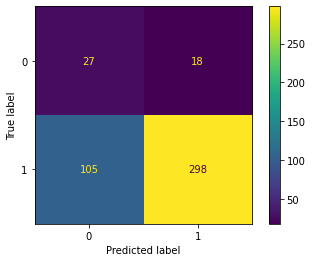

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

**Ejercicios**

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).

Otras transformaciones: [Discretización](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization) y utilización de otros clasificadores NB

In [ ]:
%%sql loans_train_2 << SELECT substr(l.date,0,3) year_loan, amount, duration, payments, A11, A13, 99 - substr(birth_number,0,3) edad ,l.date, A4 no_of_inhabitants,
CASE status WHEN 'A' THEN 1 
            WHEN 'B' THEN 0

END label
FROM LOAN l, ACCOUNT a, DISTRICT dist, CLIENT c, DISPOSITION disp
WHERE l.account_id = a.account_id and a.account_id = disp.account_id
and disp.client_id = c.client_id and c.district_id = dist.a1 
and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train_2


In [ ]:
df_train_2 = loans_train_2.DataFrame()
df_train_2.head()

,year_loan,amount,duration,payments,A11,A13,edad,date,no_of_inhabitants,label
0,94,80952,24,3373,12541,0.43,54,940105,1204953,1
1,94,80952,24,3373,12541,0.43,59,940105,1204953,1
2,96,30276,12,2523,9104,2.07,60,960429,103347,0
3,97,30276,12,2523,9893,4.72,37,971208,228848,1
4,96,165960,24,6915,8427,1.54,55,960502,93931,1


In [ ]:
df_train_2.shape

(289, 10)

In [ ]:
%%sql loans_test_2 << SELECT substr(l.date,0,3) year_loan, amount, duration, payments, A11, A13, 99 - substr(birth_number,0,3) edad ,l.date, A4 no_of_inhabitants,
CASE status WHEN 'C' THEN 1 
            WHEN 'D' THEN 0

END label
FROM LOAN l, ACCOUNT a, DISTRICT dist, CLIENT c, DISPOSITION disp
WHERE l.account_id = a.account_id and a.account_id = disp.account_id
and disp.client_id = c.client_id and c.district_id = dist.a1 
and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test_2


In [ ]:
df_test_2 = loans_test_2.DataFrame()
df_test_2.head()

,year_loan,amount,duration,payments,A11,A13,edad,date,no_of_inhabitants,label
0,98,318480,60,5308,8547,3.64,47,981014,70646,0
1,98,110736,48,2307,8402,3.98,59,980419,51428,1
2,97,265320,36,7370,8254,3.76,32,971206,105606,0
3,98,352704,48,7348,9104,2.07,49,981205,103347,1
4,97,162576,36,4516,9198,4.28,46,970908,159617,1


In [ ]:
df_test_2.shape

(538, 10)

División de los datos de entrenamiento

In [ ]:
features = ["year_loan", "amount", "duration", "payments","A11", "A13", "edad", "no_of_inhabitants"]

In [ ]:
X_train_2 = df_train_2[features]
y_train_2 = df_train_2["label"]

X_test_2 = df_test_2[features]
y_test_2 = df_test_2["label"]

Normalización:  

In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train_2) 
# transformación
X_train_2 = scaler.transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

Aplicación de modelo Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train_2, y_train_2)
y_pred = clf.predict(X_test_2)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test_2.shape[0], (y_test_2 != y_pred).sum()))

Número de préstamos clasificados erroneamente 538 de un total de  154


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_2, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.17      0.60      0.26        45
           1       0.95      0.72      0.82       493

    accuracy                           0.71       538
   macro avg       0.56      0.66      0.54       538
weighted avg       0.89      0.71      0.78       538



Matriz de confusión.

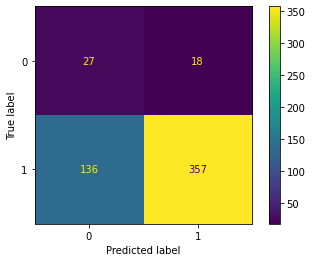

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_2, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()